In [3]:
import sys
assert sys.version_info >=(3,5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import sklearn
assert sklearn.__version__ >= "0.20"  # Changed from _version_ to __version__

import numpy as np
import os

np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt  # Fixed typo: pypot -> pyplot
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



In [4]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]

X_test = X[60000:]
y_test = y[60000:]

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))

from sklearn.svm import SVC
svm_clf = SVC()

In [6]:
# to speed up the training process, we will use a smaller subset of the training data
X_train_small = X_train_scaled[:10000]
y_train_small = y_train[:10000]

In [7]:
# do grid search with a linear kernel first to find good hyperparameters
from sklearn.model_selection import GridSearchCV
param_grid_linear = [
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']}
]
grid_search_linear = GridSearchCV(svm_clf, param_grid_linear, cv=3, verbose=2, n_jobs=-1)
grid_search_linear.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


,estimator,SVC()
,param_grid,"[{'C': [0.1, 1, ...], 'kernel': ['linear']}]"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.1


In [8]:
# how did linear kernel perform?
print("Best parameters (linear kernel):", grid_search_linear.best_params_)
print("Best cross-validation score (linear kernel):", grid_search_linear.best_score_)

# print out the scores for each hyperparameter combination
cvres_linear = grid_search_linear.cv_results_
for mean_score, params in zip(cvres_linear["mean_test_score"], cvres_linear["params"]):
    print(mean_score, params)

Best parameters (linear kernel): {'C': 0.1, 'kernel': 'linear'}
Best cross-validation score (linear kernel): 0.9114998482451725
0.9114998482451725 {'C': 0.1, 'kernel': 'linear'}
0.9109996182581664 {'C': 1, 'kernel': 'linear'}
0.9109996182581664 {'C': 10, 'kernel': 'linear'}
0.9109996182581664 {'C': 100, 'kernel': 'linear'}
0.9109996182581664 {'C': 1000, 'kernel': 'linear'}


In [9]:
# now try with rbf kernel
param_grid_rbf = [
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
]
grid_search_rbf = GridSearchCV(svm_clf, param_grid_rbf, cv=3, verbose=2, n_jobs=6)
grid_search_rbf.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,SVC()
,param_grid,"[{'C': [0.1, 1, ...], 'gamma': [0.0001, 0.001, ...], 'kernel': ['rbf']}]"
,scoring,None
,n_jobs,6
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [10]:
# rbf kernel results
print("Best parameters (rbf kernel):", grid_search_rbf.best_params_)
print("Best cross-validation score (rbf kernel):", grid_search_rbf.best_score_)

# print out the scores for each hyperparameter combination
cvres_rbf = grid_search_rbf.cv_results_
for mean_score, params in zip(cvres_rbf["mean_test_score"], cvres_rbf["params"]):
    print(mean_score, params)

Best parameters (rbf kernel): {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score (rbf kernel): 0.9394998288071159
0.7694000653814631 {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.8742995475312378 {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.4784996796020334 {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.11269999225477438 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.9018001380222005 {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.929699808613135 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.7506985251614543 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.1733003234336631 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.9284999585741417 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.9394998288071159 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.7672984754984196 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.1772002935146544 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.9264998185481416 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.9376997687771177 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0

In [10]:
# polynomial kernel, optimizing C, degree, and coef0
from sklearn.model_selection import GridSearchCV
param_grid_poly = [
    {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4], 'coef0': [-1, 0, 1], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['poly']}
]
grid_search_poly = GridSearchCV(svm_clf, param_grid_poly, cv=3, n_jobs=6, verbose=2)
grid_search_poly.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


,estimator,SVC()
,param_grid,"[{'C': [0.1, 1, ...], 'coef0': [-1, 0, ...], 'degree': [2, 3, ...], 'gamma': [0.0001, 0.001, ...], ...}]"
,scoring,None
,n_jobs,6
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.1


In [12]:
# polynomial kernel results C 1, degree 4, coef0 1, gamma scale
print("Best parameters (polynomial kernel):", grid_search_poly.best_params_)
print("Best cross-validation score (polynomial kernel):", grid_search_poly.best_score_)

# only show the best 10 parameter combinations and their scores
cvres_poly = grid_search_poly.cv_results_
cvres_poly_sorted_indices = np.argsort(cvres_poly["mean_test_score"])[::-1][:10]
for index in cvres_poly_sorted_indices:
    mean_score = cvres_poly["mean_test_score"][index]
    params = cvres_poly["params"][index]
    print(mean_score, params)

Best parameters (polynomial kernel): {'C': 0.1, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
Best cross-validation score (polynomial kernel): 0.9557000091130888
0.9557000091130888 {'C': 1000, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 0.1, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9539997491050846 {'C': 10, 'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.9539997491050846 {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.9539997491050846 {'C': 1, 'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.9539997491050846 {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.9539997491050846 {'C': 1000, 'coef0': 1, 

In [13]:
# do a more extensive grid search with the best hyperparameters found
best_poly_params = grid_search_poly.best_params_
param_grid_poly_extensive = [
    {'C': [1, 5, 10, 50, 100, 500, 1000],
     'degree': [3],
     'coef0': [1, 2],
     'gamma': [0.01, 0.05],
     'kernel': ['poly']}
]
grid_search_poly_extensive = GridSearchCV(svm_clf, param_grid_poly_extensive, cv=3, verbose=2, n_jobs=6)
grid_search_poly_extensive.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


,estimator,SVC()
,param_grid,"[{'C': [1, 5, ...], 'coef0': [1, 2], 'degree': [3], 'gamma': [0.01, 0.05], ...}]"
,scoring,None
,n_jobs,6
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [14]:
# print out 10 best results from the extensive grid search
cvres_poly_extensive = grid_search_poly_extensive.cv_results_
ranked_indices = np.argsort(cvres_poly_extensive["mean_test_score"])[::-1]
for rank in range(10):
    index = ranked_indices[rank]
    print(f"{cvres_poly_extensive['mean_test_score'][index]} {cvres_poly_extensive['params'][index]}")

0.9557000091130888 {'C': 1000, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 500, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 50, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 5, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9557000091130888 {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9539000690710943 {'C': 5, 'coef0': 2, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9539000690710943 {'C': 100, 'coef0': 2, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.9539000690710943 {'C': 500, 'coef0': 2, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}


In [31]:
# use best hyperparameter
svm_best_estimator = SVC(C=1000, coef0=1, degree=3, gamma=0.01, kernel='poly')

In [32]:
# Accuracy with scaled dataset- better than un_scaled dataset
from sklearn.model_selection import cross_val_score
cross_val_score(svm_best_estimator, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=5)

array([0.9791 , 0.97695, 0.97685])

In [33]:
#Accuracy with un-scaled dataset
cross_val_score(svm_best_estimator, X_train, y_train, cv=3, scoring='accuracy', n_jobs=5)

array([0.9749, 0.9734, 0.9737])

In [34]:
from sklearn.model_selection import cross_val_predict

y_pred_svm = cross_val_predict(svm_best_estimator, X_train_scaled, y_train, cv=3, n_jobs=5)

In [35]:
#confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# confusion matrix for svm on the best parameters
conf_matrix = confusion_matrix(y_train, y_pred_svm)

print("Confusion Matrix:\n", conf_matrix)

precision = precision_score(y_train, y_pred_svm, average='weighted')
recall = recall_score(y_train, y_pred_svm, average='weighted')
f1 = f1_score(y_train, y_pred_svm, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Confusion Matrix:
 [[5861    1   10    2    5    7   22    2   10    3]
 [   2 6675   23    6    4    1    5   13   12    1]
 [  13    8 5801   32   24    3    6   34   29    8]
 [   4    6   42 5930    2   46    0   22   59   20]
 [   6   10   23    1 5716    4   12   11    9   50]
 [  12    3    4   44    8 5285   32    1   20   12]
 [  26    7    6    1   13   28 5824    2   11    0]
 [   8   22   27    6   33    4    0 6106    5   54]
 [  12   17   16   28   15   33   15    6 5697   12]
 [  10    5   14   28   53   12    1   45   18 5763]]
Precision: 0.9776295942249674
Recall: 0.9776333333333334
F1 Score: 0.9776270734717571


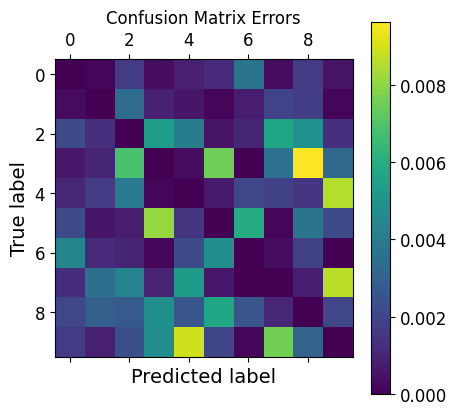

In [36]:
# visualize the confusion matrix errors in colour
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = conf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap='viridis')
plt.colorbar()
plt.title("Confusion Matrix Errors")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# SGD

In [37]:
# scaled data worked better so we are using this for SGD
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
y_train_pred_sgd = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=5)

In [38]:
# precision, recall, f1 for SGD
precision_sgd = precision_score(y_train, y_train_pred_sgd, average='weighted')
recall_sgd = recall_score(y_train, y_train_pred_sgd, average='weighted')
f1_sgd = f1_score(y_train, y_train_pred_sgd, average='weighted')

print(f"SGD Precision: {precision_sgd}")
print(f"SGD Recall: {recall_sgd}")
print(f"SGD F1 Score: {f1_sgd}")

SGD Precision: 0.9087640755899463
SGD Recall: 0.9009666666666667
SGD F1 Score: 0.9028433269853167


# Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=5)

In [40]:
# precision, recall, f1 for Random Forest
precision_forest = precision_score(y_train, y_train_pred_forest, average='weighted')
recall_forest = recall_score(y_train, y_train_pred_forest, average='weighted')
f1_forest = f1_score(y_train, y_train_pred_forest, average='weighted')

print(f"Random Forest Precision: {precision_forest}")
print(f"Random Forest Recall: {recall_forest}")
print(f"Random Forest F1 Score: {f1_forest}")

Random Forest Precision: 0.9645677791479972
Random Forest Recall: 0.9645833333333333
Random Forest F1 Score: 0.9645601142044699


# KNN

In [41]:
# we take the best hyperparameters from assignment 4: 'n_neighbors': 4, 'weights': 'distance'
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=5)
y_train_pred_knn = cross_val_predict(knn_clf, X_train_scaled, y_train, cv=3, n_jobs=5)

In [42]:
# precision, recall, f1 for KNN
precision_knn = precision_score(y_train, y_train_pred_knn, average='weighted')
recall_knn = recall_score(y_train, y_train_pred_knn, average='weighted')
f1_knn = f1_score(y_train, y_train_pred_knn, average='weighted')

print(f"KNN Precision: {precision_knn}")
print(f"KNN Recall: {recall_knn}")
print(f"KNN F1 Score: {f1_knn}")

KNN Precision: 0.9439755386666031
KNN Recall: 0.9437666666666666
KNN F1 Score: 0.9436528199402302


# Comparison

Saving figure model_comparison_scores


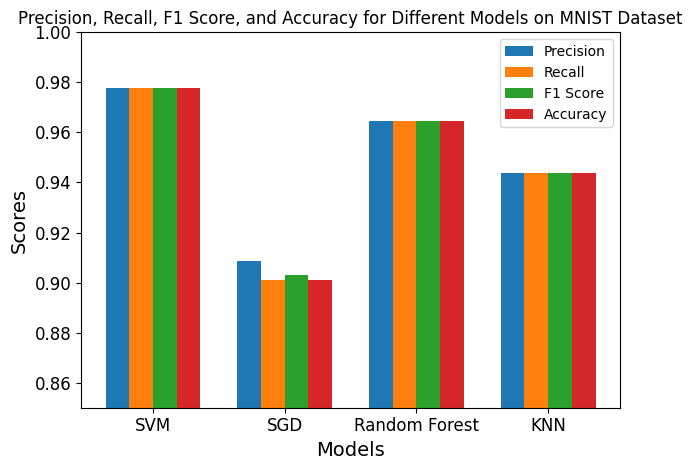

In [ ]:
# plot the precision, recall, f1, and accuracy for all models in a bar chart (y-axis between 0.8 and 1)
from sklearn.metrics import accuracy_score
models = ['SVM', 'SGD', 'Random Forest', 'KNN']
precision_scores = [precision, precision_sgd, precision_forest, precision_knn]
recall_scores = [recall, recall_sgd, recall_forest, recall_knn]
f1_scores = [f1, f1_sgd, f1_forest, f1_knn]
accuracy_scores = [
    accuracy_score(y_train, y_pred_svm),
    accuracy_score(y_train, y_train_pred_sgd),
    accuracy_score(y_train, y_train_pred_forest),
    accuracy_score(y_train, y_train_pred_knn)
 ]
x = np.arange(len(models))
width = 0.18

fig, ax = plt.subplots()
bars1 = ax.bar(x - 1.5*width, precision_scores, width, label='Precision')
bars2 = ax.bar(x - 0.5*width, recall_scores, width, label='Recall')
bars3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1 Score')
bars4 = ax.bar(x + 1.5*width, accuracy_scores, width, label='Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, F1 Score, and Accuracy for Different Models on MNIST Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.set_ylim(0.85, 1)  # Set y-axis limits to show only scores between 0.85 and 1

save_fig("model_comparison_scores")

plt.show()

In [44]:
# compare the time it takes to train and predict for each model
import time

models = {
    'SVM': svm_best_estimator,
    'SGD': sgd_clf,
    'Random Forest': forest_clf,
    'KNN': knn_clf
}

times = {}
for model_name, model in models.items():
    # Measure training time
    start_time = time.perf_counter()
    model.fit(X_train_scaled, y_train)
    training_time = time.perf_counter() - start_time

    # Measure prediction time
    start_time = time.perf_counter()
    y_pred = model.predict(X_train_scaled)
    prediction_time = time.perf_counter() - start_time

    times[model_name] = {
        'Training Time': training_time,
        'Prediction Time': prediction_time
    }

    print(f"{model_name} - Training time: {training_time:.4f}s, Prediction time: {prediction_time:.4f}s")

SVM - Training time: 243.6291s, Prediction time: 356.2132s
SGD - Training time: 292.4164s, Prediction time: 0.0680s
Random Forest - Training time: 54.4734s, Prediction time: 2.3031s
KNN - Training time: 0.1353s, Prediction time: 40.7647s


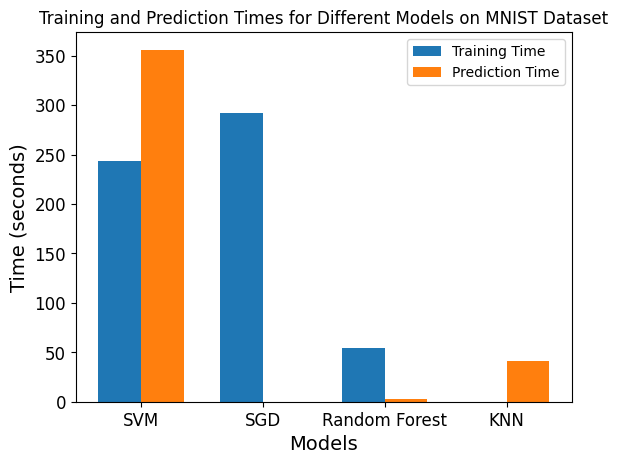

Saving figure model_comparison_times


<Figure size 640x480 with 0 Axes>

In [45]:
# plot the times in a bar chart
labels = list(times.keys())
training_times = [times[label]['Training Time'] for label in labels]
prediction_times = [times[label]['Prediction Time'] for label in labels]
x = np.arange(len(labels))
width = 0.35    
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, training_times, width, label='Training Time')
bars2 = ax.bar(x + width/2, prediction_times, width, label='Prediction Time')
ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Prediction Times for Different Models on MNIST Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

save_fig("model_comparison_times")

# Performance SVM on test data

In [46]:
# polynomial kernel results on test data
X_test_scaled = scaler.transform(X_test.astype(np.float32))
y_test_pred_svm = svm_best_estimator.predict(X_test_scaled)

# Performance SVM on test data
accuracy_test = accuracy_score(y_test, y_test_pred_svm)
precision_test = precision_score(y_test, y_test_pred_svm, average='weighted')
recall_test = recall_score(y_test, y_test_pred_svm, average='weighted')
f1_test = f1_score(y_test, y_test_pred_svm, average='weighted')

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

Test Accuracy: 0.9813
Test Precision: 0.9813028887823643
Test Recall: 0.9813
Test F1 Score: 0.9812923782229914
